In [1]:
from nn import TimeSeriesTrainer, TimeSeriesNN
import torch
import torch.nn as nn
from dataset import TimeSeriesDataset
import pandas as pd
from torch.utils.data import DataLoader
import numpy as np
from torchvision.transforms import Compose
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# Constants
SEQ_LENGTH = 10
VECTOR_SIZE = SEQ_LENGTH*12
BATCH_SIZE = 1024
DEVICE = 'mps'

In [3]:
# Transform functions for dataset

class Normalise:
    
    def __init__(self,
                 train_data,
                 seq_length) -> None:
        self.train_data = train_data
        self.mean = torch.Tensor(np.array(self.train_data.mean())).repeat(seq_length)
        self.std = torch.Tensor(np.array(self.train_data.std())).repeat(seq_length)
           
    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        if x.shape[-1]>1:
            x = (x-self.mean)/self.std
        elif x.shape[-1]==1:
            x = (x-self.mean[-1])/self.std[-1]
        return x
    
    
def to_tensor(x: np.ndarray):
    if x.ndim>0:
        return torch.Tensor(x).float()
    else:
        return torch.Tensor([x]).float()

In [4]:
train_data_df = pd.read_csv('train_delhi_aqi.csv')
val_data_df = pd.read_csv('val_delhi_aqi.csv')

transform = Compose([
    to_tensor,
    Normalise(train_data_df,SEQ_LENGTH)
])

train_data = TimeSeriesDataset(train_data_df,10,transform)
val_data = TimeSeriesDataset(val_data_df,10,transform)

train_loader = DataLoader(train_data,BATCH_SIZE,True)
val_loader = DataLoader(val_data,BATCH_SIZE)

In [5]:
neural_network = TimeSeriesNN(VECTOR_SIZE,256,256,1)

In [6]:
trainer = TimeSeriesTrainer(neural_network,train_loader,val_loader,device=DEVICE)

In [7]:
trainer.train(2)

Training:   0%|          | 0/2458 [00:00<?, ?it/s]

Epoch 1, Train Loss: 0.0565, Val Loss: 0.1050


Epoch 2, Train Loss: 0.0501, Val Loss: 0.1063
Finished Training


In [8]:
# Result on test data
test_data_df = pd.read_csv('test_delhi_aqi.csv')
test_data = TimeSeriesDataset(test_data_df,10,transform)
test_loader = DataLoader(test_data,BATCH_SIZE)

trainer.val_loader = test_loader

trainer.validate_epoch()

0.08691720813206893

In [20]:
def get_pred_vals(model,test_loader):
    model = model.to('cpu')
    pred_vals = []
    targets = []
    mean = torch.Tensor(np.array(train_data_df.mean()))[-1]
    std = torch.Tensor(np.array(train_data_df.std()))[-1]
    model.eval()  
    loop = tqdm(test_loader, desc="Validation", leave=False)
    with torch.no_grad():
        for inputs, target in loop:
            inputs, target = torch.Tensor(inputs).float(),torch.Tensor(target).float()
            outputs = model(inputs)*std + mean
            pred_vals.append(outputs)
            targets.append(target*std+mean)
    pred_vals = torch.cat(pred_vals).view(-1).cpu().numpy()
    targets = torch.cat(targets).view(-1).cpu().numpy()
    return pred_vals,targets


def plot(pred_vals, targets):
    plt.figure(figsize=(12, 6))

    plt.plot(pred_vals, label='Predicted Values', color='blue', linestyle='-')
    
    plt.plot(targets, label='Actual Targets', color='red', linestyle='-')

    # Adding title and labels
    plt.title('Comparison of Predictions and Actual AQI(Normalised) Over Time')
    plt.xlabel('Time (Hrs)')
    plt.ylabel('AQI (Normalised)')
    plt.legend(loc='best')  

    plt.grid(True)

    plt.show()
    
def calculate_mse(pred_vals,targets):
    error = (pred_vals-targets)**2
    mse = error.mean()
    return mse
    
def calculate_r2(pred_vals, targets):
    total_variance = np.sum((targets - np.mean(targets))**2)
    residual_variance = np.sum((targets - pred_vals)**2)
    # R^2 score
    r2_score = 1 - (residual_variance / total_variance)
    return r2_score


In [21]:
pred_vals,targets = get_pred_vals(neural_network,test_loader)

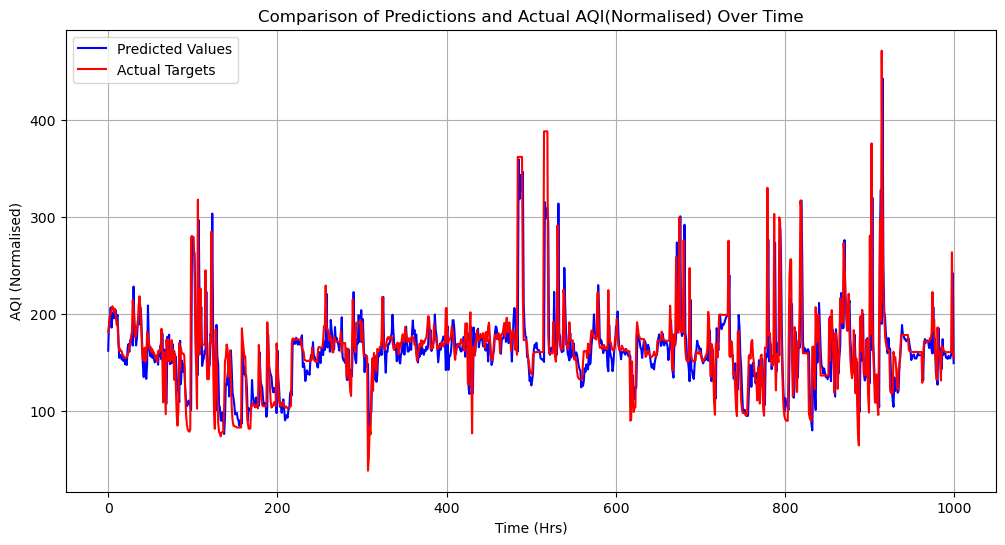

In [22]:
plot(pred_vals[:1000],targets[:1000])

In [23]:
calculate_r2(pred_vals, targets)

0.8149070888757706

In [24]:
calculate_mse(pred_vals,targets)

708.81165

In [31]:
error = np.abs(pred_vals-targets)
print(f"Max error: {error.max()}")
print(f"min error: {error.min()}")

Max error: 482.79620361328125
min error: 6.103515625e-05
